In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### AWS installation part

In [ ]:
!pip install awscli

In [ ]:
!aws configure # to enter credentials

In [ ]:
!aws s3 sync s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/ /content/T1_w --exclude "*" --include "*desc-preproc_T1w.nii.gz" --exclude "*space-MNI152NLin2009cAsym*"


download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-0050004/anat/sub-0050004_desc-preproc_T1w.nii.gz to T1_w/sub-0050004/anat/sub-0050004_desc-preproc_T1w.nii.gz
download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-0050002/anat/sub-0050002_desc-preproc_T1w.nii.gz to T1_w/sub-0050002/anat/sub-0050002_desc-preproc_T1w.nii.gz
download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-0050003/anat/sub-0050003_desc-preproc_T1w.nii.gz to T1_w/sub-0050003/anat/sub-0050003_desc-preproc_T1w.nii.gz
download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-0050005/anat/sub-0050005_desc-preproc_T1w.nii.gz to T1_w/sub-0050005/anat/sub-0050005_desc-preproc_T1w.nii.gz
download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-0050006/anat/sub-0050006_desc-preproc_T1w.nii.gz to T1_w/sub-0050006/anat/sub-0050006_desc-preproc_T1w.nii.gz
download: s3://fcp-indi/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-005000

### Generating slices

In [ ]:
!pip install nibabel

In [ ]:
import os

def extract_name(file_path):
  filename = os.path.basename(file_path)  # 'UM_1_0050325_anat_thickness.nii.gz'
  filename = filename.replace('.nii.gz', '')  # Remove both '.nii.gz'

  return filename

In [ ]:
# the dataset size is huge now, we need only 4 slices
import nibabel as nib

def create_4_slices(file_path): #stores in Drive
  img = nib.load(file_path)
  data = img.get_fdata()
  sliced_data = data[:, :, 138:142]
  new_img = nib.Nifti1Image(sliced_data, img.affine, img.header)
  name = extract_name(file_path)
  output_file = f'/content/drive/MyDrive/datasets/T1w_slices/{name}.nii.gz'
  nib.save(new_img, output_file)
  print(f"saved {name} to drive")

# create_4_slices('/content/T1_w/sub-0050002/anat/sub-0050002_desc-preproc_T1w.nii.gz')


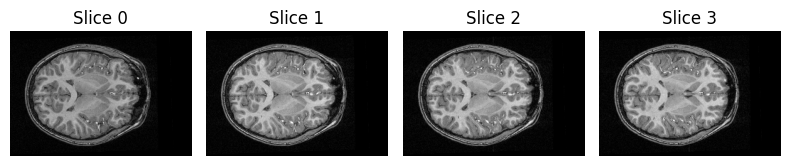

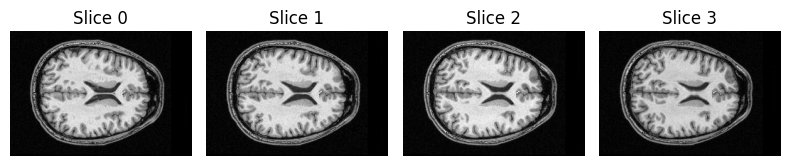

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import math

def display_all_slices_in_grid(file_path, num_columns=4):
    img = nib.load(file_path)
    data = img.get_fdata()
    num_slices = data.shape[2]

    # no. of neede rows
    num_rows = math.ceil(num_slices / num_columns)

    # displaying horizontally
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_slices):
        axes[i].imshow(data[:, :, i], cmap='gray')
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')

    for i in range(num_slices, num_rows * num_columns):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# file_path = '/content/drive/MyDrive/datasets/T1w_slices/sub-0050009_desc-preproc_T1w.nii.gz'
# display_all_slices_in_grid(file_path)
display_all_slices_in_grid('/content/drive/MyDrive/datasets/T1w_slices/sub-0050056_desc-preproc_T1w.nii.gz') #no autism
display_all_slices_in_grid('/content/drive/MyDrive/datasets/T1w_slices/sub-0050030_desc-preproc_T1w.nii.gz') #Autism




In [ ]:
# #now run a loop through T1_w to get 4 slices of every T1_w image
# parent_dir = '/content/T1_w'

# for sub_dir in os.listdir(parent_dir):
#   for scan in os.listdir(f'{parent_dir}/{sub_dir}/anat'):
#     file_path = f'{parent_dir}/{sub_dir}/anat/{scan}'
#     create_4_slices(file_path)


load these 4-sliced images from drive

In [ ]:
# !cp -r

#### Now, operate on these 4 slices

### segmentation

In [ ]:
!pip install scikit-fuzzy
!pip install scikit-learn

In [ ]:
import os
import nibabel as nib
import numpy as np
from skfuzzy import cmeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import nibabel as nib
import os
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from skfuzzy import cmeans
from PIL import Image

def extract_middle_slice(volume):
    middle_slice = volume[:, :, volume.shape[2] // 2]
    return middle_slice

# will perform segmentation
def segment_fcm_gmm_slice(slice_2d, n_clusters=2):
    scaler = MinMaxScaler()
    slice_normalized = scaler.fit_transform(slice_2d.reshape(-1, 1)).reshape(slice_2d.shape) #noramlizes pixel values- from 0 to 1

    slice_flattened = slice_normalized.ravel()
    cntr, u, _, _, _, _, _ = cmeans(slice_flattened.reshape(1, -1), n_clusters, 2, error=0.005, maxiter=1000)  #runs fuzzy c-means

    #here, u is the membership matrix- which indicates to what degree a pixel is part of a specific cluster
    fcm_labels = np.argmax(u, axis=0).reshape(slice_2d.shape)

    gmm = GaussianMixture(n_components=n_clusters) #refines the segmentation more
    gmm_labels = gmm.fit_predict(fcm_labels.reshape(-1, 1))
    gmm_labels = gmm_labels.reshape(slice_2d.shape)

    return gmm_labels

def process_and_save_middle_slice_cpu(nii_file_path, save_directory):
    nii_data = nib.load(nii_file_path)
    volume = nii_data.get_fdata()

    middle_slice = extract_middle_slice(volume)


    segmented_slice = segment_fcm_gmm_slice(middle_slice)

    segmented_slice = (segmented_slice - segmented_slice.min()) / (segmented_slice.max() - segmented_slice.min())
    segmented_slice = (segmented_slice * 255).astype(np.uint8)

    # save as jpg
    output_file_path = os.path.join(save_directory, os.path.basename(nii_file_path).replace('.nii.gz', '.jpg'))
    segmented_image = Image.fromarray(segmented_slice)
    segmented_image.save(output_file_path)

    print(f'Saved segmented middle slice file: {output_file_path}')



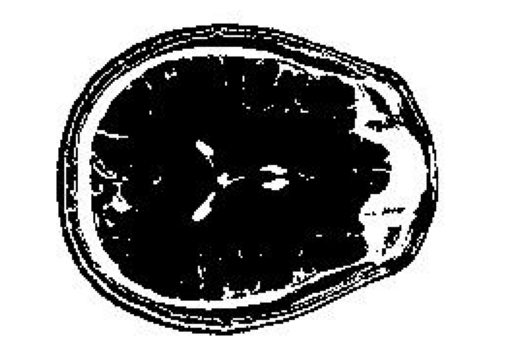

In [ ]:
#displaying example segmented scan data

import cv2
from matplotlib import pyplot as plt

image_path = "/content/drive/MyDrive/datasets/new_seg/sub-0050002_desc-preproc_T1w.jpg"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [ ]:
!pip install nibabel

In [ ]:
# # .nii.gz file in the data directory
# data_directory = '/content/final'
# os.makedirs(data_directory, exist_ok=True)


# Directory to save the segmented middle slices
save_directory = '/content/new_seg_1'
os.makedirs(save_directory, exist_ok=True)



In [ ]:
# take a single slice from the 4 slices
import os
import nibabel as nib
parent_dir = '/content/drive/MyDrive/datasets/T1w_slices'


for vol in os.listdir('/content/drive/MyDrive/datasets/T1w_slices'):
  img = nib.load(f'{parent_dir}/{vol}').get_fdata()
  if img.ndim == 3 and img.shape[2] == 4 and img.shape[0] > 0 and img.shape[1] > 0:
    #extract the middle slice from this and segment-
    process_and_save_middle_slice_cpu(f'{parent_dir}/{vol}', save_directory)



In [ ]:
# !rm -r /content/new_seg_1

building loaders for subjects under 13 years old

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import re
from PIL import Image

class newDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        labels_df = pd.read_csv(csv_file)
        self.labels_dict = dict(zip(labels_df.iloc[:, 1].astype(str).str.lstrip('0'), labels_df.iloc[:, 2]))
        self.age_dict = dict(zip(labels_df.iloc[:, 1].astype(str).str.lstrip('0'), labels_df.iloc[:, 4]))  # age column index 4

        self.image_paths = []
        self.labels = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                match = re.search(r'sub-(\d+)_desc-preproc_T1w.jpg$', filename)
                if match:
                    subject_id = match.group(1).lstrip('0')
                    label = self.labels_dict.get(subject_id, None)
                    age = self.age_dict.get(subject_id, None)

                    if label is not None and age is not None and age < 13:
                        self.image_paths.append(os.path.join(image_dir, filename))
                        self.labels.append(0 if label == 1 else 1)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.float32)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

csv_file = '/content/Phenotypic_V1_0b.csv'
image_dir = '/content/drive/MyDrive/datasets/new_seg'
dataset = newDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(77)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator) #random split- before


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Testing set size: {len(test_loader.dataset)}")


Training set size: 277
Testing set size: 70


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class ResNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNetBinaryClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetBinaryClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), '/content/model_adult.pth')
    print("Model saved")


In [ ]:
from sklearn.metrics import roc_auc_score

def test_model_1(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            TP += ((predicted == 1) & (labels == 1)).sum().item()
            FP += ((predicted == 1) & (labels == 0)).sum().item()
            FN += ((predicted == 0) & (labels == 1)).sum().item()
            TN += ((predicted == 0) & (labels == 0)).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    auc_score = roc_auc_score(all_labels, all_outputs)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"AUC Score: {auc_score:.4f}")


In [ ]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


In [ ]:
# Training the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Testing the model
test_model_1(model, test_loader, criterion)


Epoch [1/10], Loss: 0.7750
Epoch [2/10], Loss: 0.5374
Epoch [3/10], Loss: 0.3261
Epoch [4/10], Loss: 0.1385
Epoch [5/10], Loss: 0.0355
Epoch [6/10], Loss: 0.0153
Epoch [7/10], Loss: 0.0082
Epoch [8/10], Loss: 0.0073
Epoch [9/10], Loss: 0.0127
Epoch [10/10], Loss: 0.0249
Model saved


NameError: name 'test_model' is not defined

In [ ]:
def load_model(model_path, device):
    model = ResNetBinaryClassifier().to(device)  # Initialize the model
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights
    model.eval()  # Set the model to evaluation mode
    return model


In [ ]:
model_path = '/content/drive/MyDrive/datasets/model_kid_1.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(model_path, device)

test_model_1(model, test_loader, criterion)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-9-343051c21094>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

Test Loss: 0.2238
Test Accuracy: 94.29%
Precision: 0.8857
Recall: 1.0000
F1 Score: 0.9394
AUC Score: 0.9892


In [ ]:
!cp -r /content/new_seg /content/drive/MyDrive/datasets

In [ ]:
!cp -r /content/model_kid_1.pth /content/drive/MyDrive/datasets